In [1]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from datetime import date
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

# Data Cleaning

## Data Descriptions and Details
__YEAR, MONTH, DAY, DAY_OF_WEEK__: dates of the flight <br>
__AIRLINE__: An identification number assigned by US DOT to identify a unique airline<br>
__ORIGIN_AIRPORT and DESTINATION_AIRPORT__: code attributed by IATA to identify the airports<br>
__SCHEDULED_DEPARTURE and SCHEDULED_ARRIVAL__ : scheduled times of take-off and landing<br>
__DEPARTURE_TIME and ARRIVAL_TIME__: real times at which take-off and landing took place<br>
__DEPARTURE_DELAY and ARRIVAL_DELAY__: difference (in minutes) between planned and real times<br>
__DISTANCE__: distance (in miles)<br>
__TAXI_IN__:The time duration elapsed between wheels-on and gate arrival at the destination airport
__TAXI_OUT__: The time duration elapsed between departure from the origin airport gate and wheels off<br>
__WHEELS_ON__:The time point that the aircraft's wheels touch on the ground<br>
__WHEELS_OFF__: The time point that the aircraft's wheels leave the ground<br>
__AIR_TIME__:The time duration between wheels_off and wheels_on time<br>
__ELAPSED_TIME__:AIR_TIME+TAXI_IN+TAXI_OUT<br>
__DISTANCE__:Distance between two airports<br>
__SCHEDULED_TIME__:Planned time amount needed for the flight trip<br>


In [2]:
# df = pd.read_csv('./flight-delays/flights.csv', low_memory=False)
# df.head(10)

In [3]:
# df.shape

There are 5,8 millions data which will be too slow for the training and ploting the data. Thus, for this project I will only use partial of the data which taken randomly

In [4]:
# dfFlights = df.sample(frac=0.05)

In [5]:
# dfFlights.shape

dfFlights.to_csv('Flights_sample.csv',index=False)

In [6]:
dfFlights = pd.read_csv('Flights_sample.csv')

In [7]:
dfFlights.shape

(290954, 31)

In [8]:
def table_data(df):
    data=[]
    n=2
    for item in df.columns:
        if df[item].nunique()==1:
            n=1
        else:
            n=2
        data.append([
                    item,
                    df.dtypes.loc[item],
                    df[item].isna().sum(),
                    df[item].isna().sum()/len(df[item])*100,
                    df[item].nunique(),
                    list(df[df[item].notnull()].drop_duplicates(subset=item)[item].sample(n=n))
                    ])

    df_info = pd.DataFrame(data=data, columns=['dataFeatures', 'dataType','null','nullPct','unique','sample'])
    return df_info

In [9]:
df_info = table_data(dfFlights)

In [10]:
df_info

,dataFeatures,dataType,null,nullPct,unique,sample
0,YEAR,int64,0,0.000000,1,[2015]
1,MONTH,int64,0,0.000000,12,"[12, 6]"
2,DAY,int64,0,0.000000,31,"[26, 12]"
3,DAY_OF_WEEK,int64,0,0.000000,7,"[3, 6]"
4,AIRLINE,object,0,0.000000,14,"[DL, WN]"
5,FLIGHT_NUMBER,int64,0,0.000000,6588,"[5997, 1444]"
6,TAIL_NUMBER,object,761,0.261553,4754,"[N127SY, N4YUAA]"
7,ORIGIN_AIRPORT,object,0,0.000000,618,"[10551, MDT]"
8,DESTINATION_AIRPORT,object,0,0.000000,621,"[TLH, 14783]"
9,SCHEDULED_DEPARTURE,int64,0,0.000000,1256,"[2037, 2023]"


### Data Cleaning

['CANCELLATION_REASON','AIR_SYSTEM_DELAY',
'SECURITY_DELAY','AIRLINE_DELAY','LATE_AIRCRAFT_DELAY','WEATHER_DELAY'] These Collums have >80% of null value, so These collumns will be dropped. As for the other nulll values which is less than 1% and the dataset provide good amount of data, so those row with the null values will also be dropped. Also some of unimportant feature such as Flight number and tail number

In [11]:
variables_to_remove = [ 'AIR_SYSTEM_DELAY','SECURITY_DELAY', 'AIRLINE_DELAY'
                       ,'LATE_AIRCRAFT_DELAY','WEATHER_DELAY', 'DIVERTED',
                       'CANCELLED', 'CANCELLATION_REASON',
                       'FLIGHT_NUMBER', 'TAIL_NUMBER']
df = dfFlights.drop(variables_to_remove, axis = 1)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290954 entries, 0 to 290953
Data columns (total 21 columns):
YEAR                   290954 non-null int64
MONTH                  290954 non-null int64
DAY                    290954 non-null int64
DAY_OF_WEEK            290954 non-null int64
AIRLINE                290954 non-null object
ORIGIN_AIRPORT         290954 non-null object
DESTINATION_AIRPORT    290954 non-null object
SCHEDULED_DEPARTURE    290954 non-null int64
DEPARTURE_TIME         286509 non-null float64
DEPARTURE_DELAY        286509 non-null float64
TAXI_OUT               286335 non-null float64
WHEELS_OFF             286335 non-null float64
SCHEDULED_TIME         290954 non-null float64
ELAPSED_TIME           285509 non-null float64
AIR_TIME               285509 non-null float64
DISTANCE               290954 non-null int64
WHEELS_ON              286165 non-null float64
TAXI_IN                286165 non-null float64
SCHEDULED_ARRIVAL      290954 non-null int64
ARRIVAL_TIME 

In [13]:
df.dropna(inplace=True)

In [14]:
df_info = table_data(df)
df_info

,dataFeatures,dataType,null,nullPct,unique,sample
0,YEAR,int64,0,0.0,1,[2015]
1,MONTH,int64,0,0.0,12,"[7, 1]"
2,DAY,int64,0,0.0,31,"[29, 4]"
3,DAY_OF_WEEK,int64,0,0.0,7,"[6, 5]"
4,AIRLINE,object,0,0.0,14,"[OO, VX]"
5,ORIGIN_AIRPORT,object,0,0.0,617,"[EGE, 16218]"
6,DESTINATION_AIRPORT,object,0,0.0,621,"[ABE, PBI]"
7,SCHEDULED_DEPARTURE,int64,0,0.0,1256,"[2137, 1552]"
8,DEPARTURE_TIME,float64,0,0.0,1385,"[1948.0, 1858.0]"
9,DEPARTURE_DELAY,float64,0,0.0,591,"[123.0, 147.0]"


In [15]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY
0,2015,4,4,6,UA,FLL,CLE,1104,1059.0,-5.0,13.0,1112.0,176.0,171.0,149.0,1062,1341.0,9.0,1400,1350.0,-10.0
1,2015,6,22,1,WN,PHX,LAX,900,1018.0,78.0,14.0,1032.0,90.0,75.0,53.0,370,1125.0,8.0,1030,1133.0,63.0
2,2015,12,27,7,DL,SAN,DTW,1135,1129.0,-6.0,29.0,1158.0,264.0,264.0,229.0,1956,1847.0,6.0,1859,1853.0,-6.0
3,2015,5,21,4,WN,MKE,RSW,605,558.0,-7.0,17.0,615.0,175.0,172.0,151.0,1183,946.0,4.0,1000,950.0,-10.0
4,2015,7,5,7,WN,MDW,CLE,2215,2213.0,-2.0,14.0,2227.0,65.0,71.0,50.0,307,17.0,7.0,20,24.0,4.0


___To make the data cleaner, the YEAR,MONTH,DAY, and other time relative columns are transformed into datetime python library format___

In [16]:
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH', 'DAY']])

In [17]:
#_________________________________________________________
# Function that convert the 'HHMM' string to datetime.time
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure
#_____________________________________________________________________
# Function that combines a date and time to produce a datetime.datetime
def combine_date_heure(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])
#_______________________________________________________________________________
# Function that combine two columns of the dataframe to create a datetime format
def create_flight_time(df, col):    
    liste = []
    for index, cols in df[['DATE', col]].iterrows():    
        if pd.isnull(cols[1]):
            liste.append(np.nan)
        elif float(cols[1]) == 2400:
            cols[0] += datetime.timedelta(days=1)
            cols[1] = datetime.time(0,0)
            liste.append(combine_date_heure(cols))
        else:
            cols[1] = format_heure(cols[1])
            liste.append(combine_date_heure(cols))
    return pd.Series(liste)

In [18]:
df['SCHEDULED_DEPARTURE'] = create_flight_time(df, 'SCHEDULED_DEPARTURE')
df['SCHEDULED_DEPARTURE'] = pd.to_datetime(df['SCHEDULED_DEPARTURE'])
# df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].apply(format_heure)
df['DEPARTURE_TIME'] = create_flight_time(df, 'DEPARTURE_TIME')
df['DEPARTURE_TIME'] = pd.to_datetime(df['DEPARTURE_TIME'])
# df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].to_timestamp()
# df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].apply(format_heure)
df['SCHEDULED_ARRIVAL'] = create_flight_time(df, 'SCHEDULED_ARRIVAL')
df['SCHEDULED_ARRIVAL'] = pd.to_datetime(df['SCHEDULED_ARRIVAL'])
# df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].to_timestamp()
# df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].apply(format_heure)
df['ARRIVAL_TIME'] = create_flight_time(df, 'ARRIVAL_TIME')
df['ARRIVAL_TIME'] = pd.to_datetime(df['ARRIVAL_TIME'])
# df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].to_timestamp()

In [19]:
df.loc[:5, ['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'DEPARTURE_TIME',
             'ARRIVAL_TIME', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY']]

,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DEPARTURE_TIME,ARRIVAL_TIME,DEPARTURE_DELAY,ARRIVAL_DELAY
0,2015-04-04 11:04:00,2015-04-04 14:00:00,2015-04-04 10:59:00,2015-04-04 13:50:00,-5.0,-10.0
1,2015-06-22 09:00:00,2015-06-22 10:30:00,2015-06-22 10:18:00,2015-06-22 11:33:00,78.0,63.0
2,2015-12-27 11:35:00,2015-12-27 18:59:00,2015-12-27 11:29:00,2015-12-27 18:53:00,-6.0,-6.0
3,2015-05-21 06:05:00,2015-05-21 10:00:00,2015-05-21 05:58:00,2015-05-21 09:50:00,-7.0,-10.0
4,2015-07-05 22:15:00,2015-07-05 00:20:00,2015-07-05 22:13:00,2015-07-05 00:24:00,-2.0,4.0
5,2015-11-06 08:40:00,2015-11-06 12:07:00,2015-11-06 08:39:00,2015-11-06 12:03:00,-1.0,-4.0


In [20]:
remove_date=['YEAR','MONTH','DAY','DAY_OF_WEEK']
df= df.drop(remove_date, axis = 1)

In [21]:
df.head()

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DATE
0,UA,FLL,CLE,2015-04-04 11:04:00,2015-04-04 10:59:00,-5.0,13.0,1112.0,176.0,171.0,149.0,1062,1341.0,9.0,2015-04-04 14:00:00,2015-04-04 13:50:00,-10.0,2015-04-04
1,WN,PHX,LAX,2015-06-22 09:00:00,2015-06-22 10:18:00,78.0,14.0,1032.0,90.0,75.0,53.0,370,1125.0,8.0,2015-06-22 10:30:00,2015-06-22 11:33:00,63.0,2015-06-22
2,DL,SAN,DTW,2015-12-27 11:35:00,2015-12-27 11:29:00,-6.0,29.0,1158.0,264.0,264.0,229.0,1956,1847.0,6.0,2015-12-27 18:59:00,2015-12-27 18:53:00,-6.0,2015-12-27
3,WN,MKE,RSW,2015-05-21 06:05:00,2015-05-21 05:58:00,-7.0,17.0,615.0,175.0,172.0,151.0,1183,946.0,4.0,2015-05-21 10:00:00,2015-05-21 09:50:00,-10.0,2015-05-21
4,WN,MDW,CLE,2015-07-05 22:15:00,2015-07-05 22:13:00,-2.0,14.0,2227.0,65.0,71.0,50.0,307,17.0,7.0,2015-07-05 00:20:00,2015-07-05 00:24:00,4.0,2015-07-05


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285509 entries, 0 to 290953
Data columns (total 18 columns):
AIRLINE                285509 non-null object
ORIGIN_AIRPORT         285509 non-null object
DESTINATION_AIRPORT    285509 non-null object
SCHEDULED_DEPARTURE    280181 non-null datetime64[ns]
DEPARTURE_TIME         280181 non-null datetime64[ns]
DEPARTURE_DELAY        285509 non-null float64
TAXI_OUT               285509 non-null float64
WHEELS_OFF             285509 non-null float64
SCHEDULED_TIME         285509 non-null float64
ELAPSED_TIME           285509 non-null float64
AIR_TIME               285509 non-null float64
DISTANCE               285509 non-null int64
WHEELS_ON              285509 non-null float64
TAXI_IN                285509 non-null float64
SCHEDULED_ARRIVAL      280181 non-null datetime64[ns]
ARRIVAL_TIME           280181 non-null datetime64[ns]
ARRIVAL_DELAY          285509 non-null float64
DATE                   285509 non-null datetime64[ns]
dtypes: datet

In [23]:
df = df[['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT','DISTANCE',
    'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
    'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY','TAXI_OUT',
    'WHEELS_OFF','AIR_TIME','WHEELS_ON','TAXI_IN', 'ELAPSED_TIME',
    'SCHEDULED_TIME']]

In [24]:
df.dropna(inplace=True)

In [25]:
df['ARRIVAL_TIME'][0]

Timestamp('2015-04-04 13:50:00')

In [26]:
df.describe()

,DISTANCE,DEPARTURE_DELAY,ARRIVAL_DELAY,TAXI_OUT,WHEELS_OFF,AIR_TIME,WHEELS_ON,TAXI_IN,ELAPSED_TIME,SCHEDULED_TIME
count,280181.000000,280181.000000,280181.000000,280181.000000,280181.000000,280181.000000,280181.000000,280181.000000,280181.000000,280181.000000
mean,826.098383,9.213833,4.324922,16.090848,1358.295006,113.724253,1472.943519,7.420564,137.235666,142.124577
std,608.674864,36.503170,38.881274,8.936675,497.523184,72.267049,521.293249,5.621106,74.246770,75.366521
min,31.000000,-82.000000,-80.000000,1.000000,1.000000,8.000000,1.000000,1.000000,16.000000,18.000000
25%,374.000000,-5.000000,-13.000000,11.000000,937.000000,61.000000,1056.000000,4.000000,83.000000,86.000000
50%,651.000000,-2.000000,-5.000000,14.000000,1344.000000,95.000000,1509.000000,6.000000,119.000000,123.000000
75%,1065.000000,7.000000,8.000000,19.000000,1755.000000,144.000000,1912.000000,9.000000,168.000000,174.000000
max,4983.000000,1475.000000,1463.000000,200.000000,2400.000000,661.000000,2400.000000,176.000000,715.000000,718.000000


In [27]:
# duration = datetime.datetime.combine(date.min, df['ARRIVAL_TIME'][0]) - datetime.datetime.combine(date.min,df['SCHEDULED_ARRIVAL'][0])

In [28]:
def time_delta(x):
    arr =x['ARRIVAL_TIME']
    sched = x['SCHEDULED_ARRIVAL']
    duration = datetime.datetime.combine(date.min, arr) - datetime.datetime.combine(date.min,sched)
    return duration

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280181 entries, 0 to 285508
Data columns (total 17 columns):
AIRLINE                280181 non-null object
ORIGIN_AIRPORT         280181 non-null object
DESTINATION_AIRPORT    280181 non-null object
DISTANCE               280181 non-null int64
SCHEDULED_DEPARTURE    280181 non-null datetime64[ns]
DEPARTURE_TIME         280181 non-null datetime64[ns]
DEPARTURE_DELAY        280181 non-null float64
SCHEDULED_ARRIVAL      280181 non-null datetime64[ns]
ARRIVAL_TIME           280181 non-null datetime64[ns]
ARRIVAL_DELAY          280181 non-null float64
TAXI_OUT               280181 non-null float64
WHEELS_OFF             280181 non-null float64
AIR_TIME               280181 non-null float64
WHEELS_ON              280181 non-null float64
TAXI_IN                280181 non-null float64
ELAPSED_TIME           280181 non-null float64
SCHEDULED_TIME         280181 non-null float64
dtypes: datetime64[ns](4), float64(9), int64(1), object(3)
memory u

In [30]:
df['TOTAL_DELAY']=(df['ARRIVAL_TIME']-df['SCHEDULED_ARRIVAL']) #.astype('timedelta64[m]')
# df['TOTAL_DELAY']=df[['ARRIVAL_TIME','SCHEDULED_ARRIVAL']].apply(time_delta,axis=1)

In [31]:
df.head()

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DISTANCE,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,TAXI_OUT,WHEELS_OFF,AIR_TIME,WHEELS_ON,TAXI_IN,ELAPSED_TIME,SCHEDULED_TIME,TOTAL_DELAY
0,UA,FLL,CLE,1062,2015-04-04 11:04:00,2015-04-04 10:59:00,-5.0,2015-04-04 14:00:00,2015-04-04 13:50:00,-10.0,13.0,1112.0,149.0,1341.0,9.0,171.0,176.0,-1 days +23:50:00
1,WN,PHX,LAX,370,2015-06-22 09:00:00,2015-06-22 10:18:00,78.0,2015-06-22 10:30:00,2015-06-22 11:33:00,63.0,14.0,1032.0,53.0,1125.0,8.0,75.0,90.0,01:03:00
2,DL,SAN,DTW,1956,2015-12-27 11:35:00,2015-12-27 11:29:00,-6.0,2015-12-27 18:59:00,2015-12-27 18:53:00,-6.0,29.0,1158.0,229.0,1847.0,6.0,264.0,264.0,-1 days +23:54:00
3,WN,MKE,RSW,1183,2015-05-21 06:05:00,2015-05-21 05:58:00,-7.0,2015-05-21 10:00:00,2015-05-21 09:50:00,-10.0,17.0,615.0,151.0,946.0,4.0,172.0,175.0,-1 days +23:50:00
4,WN,MDW,CLE,307,2015-07-05 22:15:00,2015-07-05 22:13:00,-2.0,2015-07-05 00:20:00,2015-07-05 00:24:00,4.0,14.0,2227.0,50.0,17.0,7.0,71.0,65.0,00:04:00


In [32]:
def timedelta_format(x):
        sec = x.total_seconds()
        min_ = sec/60
        return min_

In [33]:
df['TOTAL_DELAY_MIN'] = df['TOTAL_DELAY'].apply(timedelta_format)

In [34]:
df.head()

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DISTANCE,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,TAXI_OUT,WHEELS_OFF,AIR_TIME,WHEELS_ON,TAXI_IN,ELAPSED_TIME,SCHEDULED_TIME,TOTAL_DELAY,TOTAL_DELAY_MIN
0,UA,FLL,CLE,1062,2015-04-04 11:04:00,2015-04-04 10:59:00,-5.0,2015-04-04 14:00:00,2015-04-04 13:50:00,-10.0,13.0,1112.0,149.0,1341.0,9.0,171.0,176.0,-1 days +23:50:00,-10.0
1,WN,PHX,LAX,370,2015-06-22 09:00:00,2015-06-22 10:18:00,78.0,2015-06-22 10:30:00,2015-06-22 11:33:00,63.0,14.0,1032.0,53.0,1125.0,8.0,75.0,90.0,01:03:00,63.0
2,DL,SAN,DTW,1956,2015-12-27 11:35:00,2015-12-27 11:29:00,-6.0,2015-12-27 18:59:00,2015-12-27 18:53:00,-6.0,29.0,1158.0,229.0,1847.0,6.0,264.0,264.0,-1 days +23:54:00,-6.0
3,WN,MKE,RSW,1183,2015-05-21 06:05:00,2015-05-21 05:58:00,-7.0,2015-05-21 10:00:00,2015-05-21 09:50:00,-10.0,17.0,615.0,151.0,946.0,4.0,172.0,175.0,-1 days +23:50:00,-10.0
4,WN,MDW,CLE,307,2015-07-05 22:15:00,2015-07-05 22:13:00,-2.0,2015-07-05 00:20:00,2015-07-05 00:24:00,4.0,14.0,2227.0,50.0,17.0,7.0,71.0,65.0,00:04:00,4.0


In [35]:
df['DELAY']=df['TOTAL_DELAY_MIN'].apply(lambda x:1 if x>0 else 0)

In [36]:
df.head()

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DISTANCE,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,TAXI_OUT,WHEELS_OFF,AIR_TIME,WHEELS_ON,TAXI_IN,ELAPSED_TIME,SCHEDULED_TIME,TOTAL_DELAY,TOTAL_DELAY_MIN,DELAY
0,UA,FLL,CLE,1062,2015-04-04 11:04:00,2015-04-04 10:59:00,-5.0,2015-04-04 14:00:00,2015-04-04 13:50:00,-10.0,13.0,1112.0,149.0,1341.0,9.0,171.0,176.0,-1 days +23:50:00,-10.0,0
1,WN,PHX,LAX,370,2015-06-22 09:00:00,2015-06-22 10:18:00,78.0,2015-06-22 10:30:00,2015-06-22 11:33:00,63.0,14.0,1032.0,53.0,1125.0,8.0,75.0,90.0,01:03:00,63.0,1
2,DL,SAN,DTW,1956,2015-12-27 11:35:00,2015-12-27 11:29:00,-6.0,2015-12-27 18:59:00,2015-12-27 18:53:00,-6.0,29.0,1158.0,229.0,1847.0,6.0,264.0,264.0,-1 days +23:54:00,-6.0,0
3,WN,MKE,RSW,1183,2015-05-21 06:05:00,2015-05-21 05:58:00,-7.0,2015-05-21 10:00:00,2015-05-21 09:50:00,-10.0,17.0,615.0,151.0,946.0,4.0,172.0,175.0,-1 days +23:50:00,-10.0,0
4,WN,MDW,CLE,307,2015-07-05 22:15:00,2015-07-05 22:13:00,-2.0,2015-07-05 00:20:00,2015-07-05 00:24:00,4.0,14.0,2227.0,50.0,17.0,7.0,71.0,65.0,00:04:00,4.0,1


In [37]:
df_info = table_data(df)
df_info

,dataFeatures,dataType,null,nullPct,unique,sample
0,AIRLINE,object,0,0.0,14,"[F9, B6]"
1,ORIGIN_AIRPORT,object,0,0.0,616,"[FSD, BWI]"
2,DESTINATION_AIRPORT,object,0,0.0,621,"[14952, AKN]"
3,DISTANCE,int64,0,0.0,1320,"[1411, 942]"
4,SCHEDULED_DEPARTURE,datetime64[ns],0,0.0,134513,"[2015-02-06 19:43:00, 2015-09-28 15:57:00]"
5,DEPARTURE_TIME,datetime64[ns],0,0.0,197851,"[2015-08-19 08:19:00, 2015-05-15 19:28:00]"
6,DEPARTURE_DELAY,float64,0,0.0,587,"[131.0, 450.0]"
7,SCHEDULED_ARRIVAL,datetime64[ns],0,0.0,182410,"[2015-10-10 18:39:00, 2015-03-01 06:36:00]"
8,ARRIVAL_TIME,datetime64[ns],0,0.0,201406,"[2015-06-26 08:51:00, 2015-03-11 04:58:00]"
9,ARRIVAL_DELAY,float64,0,0.0,615,"[99.0, 958.0]"


In [38]:
df_info = table_data(df)
df_info

,dataFeatures,dataType,null,nullPct,unique,sample
0,AIRLINE,object,0,0.0,14,"[HA, UA]"
1,ORIGIN_AIRPORT,object,0,0.0,616,"[10561, VLD]"
2,DESTINATION_AIRPORT,object,0,0.0,621,"[BTV, 14492]"
3,DISTANCE,int64,0,0.0,1320,"[689, 2172]"
4,SCHEDULED_DEPARTURE,datetime64[ns],0,0.0,134513,"[2015-10-31 17:05:00, 2015-05-15 23:32:00]"
5,DEPARTURE_TIME,datetime64[ns],0,0.0,197851,"[2015-05-02 09:35:00, 2015-06-24 19:30:00]"
6,DEPARTURE_DELAY,float64,0,0.0,587,"[58.0, 52.0]"
7,SCHEDULED_ARRIVAL,datetime64[ns],0,0.0,182410,"[2015-07-06 18:14:00, 2015-05-27 11:43:00]"
8,ARRIVAL_TIME,datetime64[ns],0,0.0,201406,"[2015-04-30 20:20:00, 2015-08-22 20:45:00]"
9,ARRIVAL_DELAY,float64,0,0.0,615,"[652.0, 368.0]"


In [39]:
df['DELAY'].value_counts()

0    180515
1     99666
Name: DELAY, dtype: int64

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280181 entries, 0 to 285508
Data columns (total 20 columns):
AIRLINE                280181 non-null object
ORIGIN_AIRPORT         280181 non-null object
DESTINATION_AIRPORT    280181 non-null object
DISTANCE               280181 non-null int64
SCHEDULED_DEPARTURE    280181 non-null datetime64[ns]
DEPARTURE_TIME         280181 non-null datetime64[ns]
DEPARTURE_DELAY        280181 non-null float64
SCHEDULED_ARRIVAL      280181 non-null datetime64[ns]
ARRIVAL_TIME           280181 non-null datetime64[ns]
ARRIVAL_DELAY          280181 non-null float64
TAXI_OUT               280181 non-null float64
WHEELS_OFF             280181 non-null float64
AIR_TIME               280181 non-null float64
WHEELS_ON              280181 non-null float64
TAXI_IN                280181 non-null float64
ELAPSED_TIME           280181 non-null float64
SCHEDULED_TIME         280181 non-null float64
TOTAL_DELAY            280181 non-null timedelta64[ns]
TOTAL_DELAY_

In [41]:
airlines = pd.read_csv('./flight-delays/airlines.csv')
airlines

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [42]:
abbr_airlines = airlines.set_index('IATA_CODE')['AIRLINE'].to_dict()
abbr_airlines

{'UA': 'United Air Lines Inc.',
 'AA': 'American Airlines Inc.',
 'US': 'US Airways Inc.',
 'F9': 'Frontier Airlines Inc.',
 'B6': 'JetBlue Airways',
 'OO': 'Skywest Airlines Inc.',
 'AS': 'Alaska Airlines Inc.',
 'NK': 'Spirit Air Lines',
 'WN': 'Southwest Airlines Co.',
 'DL': 'Delta Air Lines Inc.',
 'EV': 'Atlantic Southeast Airlines',
 'HA': 'Hawaiian Airlines Inc.',
 'MQ': 'American Eagle Airlines Inc.',
 'VX': 'Virgin America'}

In [43]:
df['ABBR_AIRLINE']=df['AIRLINE'].apply(lambda x :abbr_airlines[x])

In [44]:
df = df[['AIRLINE','ABBR_AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
    'DISTANCE', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
    'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY','TAXI_OUT',
    'WHEELS_OFF','AIR_TIME','WHEELS_ON','TAXI_IN', 'ELAPSED_TIME',
    'SCHEDULED_TIME','TOTAL_DELAY','TOTAL_DELAY_MIN','DELAY']]

df.to_csv('flights_sample_cleaned.csv',index=False)

df = pd.read_csv('flights_sample_cleaned.csv')

In [45]:
df.head()

,AIRLINE,ABBR_AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DISTANCE,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,TAXI_OUT,WHEELS_OFF,AIR_TIME,WHEELS_ON,TAXI_IN,ELAPSED_TIME,SCHEDULED_TIME,TOTAL_DELAY,TOTAL_DELAY_MIN,DELAY
0,UA,United Air Lines Inc.,FLL,CLE,1062,2015-04-04 11:04:00,2015-04-04 10:59:00,-5.0,2015-04-04 14:00:00,2015-04-04 13:50:00,-10.0,13.0,1112.0,149.0,1341.0,9.0,171.0,176.0,-1 days +23:50:00,-10.0,0
1,WN,Southwest Airlines Co.,PHX,LAX,370,2015-06-22 09:00:00,2015-06-22 10:18:00,78.0,2015-06-22 10:30:00,2015-06-22 11:33:00,63.0,14.0,1032.0,53.0,1125.0,8.0,75.0,90.0,01:03:00,63.0,1
2,DL,Delta Air Lines Inc.,SAN,DTW,1956,2015-12-27 11:35:00,2015-12-27 11:29:00,-6.0,2015-12-27 18:59:00,2015-12-27 18:53:00,-6.0,29.0,1158.0,229.0,1847.0,6.0,264.0,264.0,-1 days +23:54:00,-6.0,0
3,WN,Southwest Airlines Co.,MKE,RSW,1183,2015-05-21 06:05:00,2015-05-21 05:58:00,-7.0,2015-05-21 10:00:00,2015-05-21 09:50:00,-10.0,17.0,615.0,151.0,946.0,4.0,172.0,175.0,-1 days +23:50:00,-10.0,0
4,WN,Southwest Airlines Co.,MDW,CLE,307,2015-07-05 22:15:00,2015-07-05 22:13:00,-2.0,2015-07-05 00:20:00,2015-07-05 00:24:00,4.0,14.0,2227.0,50.0,17.0,7.0,71.0,65.0,00:04:00,4.0,1


In [46]:
df[df['TOTAL_DELAY_MIN'] <-100].sort_values(by='TOTAL_DELAY_MIN',ascending=False)

,AIRLINE,ABBR_AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DISTANCE,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,TAXI_OUT,WHEELS_OFF,AIR_TIME,WHEELS_ON,TAXI_IN,ELAPSED_TIME,SCHEDULED_TIME,TOTAL_DELAY,TOTAL_DELAY_MIN,DELAY
118614,AA,American Airlines Inc.,DEN,DFW,641,2015-04-28 11:20:00,2015-04-28 09:07:00,8.0,2015-04-28 13:58:00,2015-04-28 11:23:00,11.0,26.0,834.0,87.0,1101.0,11.0,124.0,121.0,-1 days +21:25:00,-155.0,0
11585,UA,United Air Lines Inc.,MCO,EWR,937,2015-05-12 14:32:00,2015-05-12 12:01:00,-7.0,2015-05-12 16:48:00,2015-05-12 14:02:00,-32.0,12.0,1000.0,122.0,1202.0,6.0,140.0,165.0,-1 days +21:14:00,-166.0,0
81869,DL,Delta Air Lines Inc.,JAX,ATL,270,2015-03-30 08:30:00,2015-03-30 05:24:00,-3.0,2015-03-30 14:18:00,2015-03-30 11:21:00,-20.0,11.0,1938.0,45.0,2023.0,6.0,62.0,79.0,-1 days +21:03:00,-177.0,0
264633,OO,Skywest Airlines Inc.,DTW,IAH,1075,2015-02-26 09:30:00,2015-02-26 06:20:00,-5.0,2015-02-26 10:41:00,2015-02-26 07:32:00,5.0,25.0,913.0,178.0,1111.0,3.0,206.0,196.0,-1 days +20:51:00,-189.0,0
74849,MQ,American Eagle Airlines Inc.,MOB,DFW,539,2015-05-14 08:50:00,2015-05-14 05:08:00,43.0,2015-05-14 12:48:00,2015-05-14 09:00:00,61.0,5.0,1505.0,92.0,1637.0,36.0,133.0,115.0,-1 days +20:12:00,-228.0,0
91606,UA,United Air Lines Inc.,11618,14908,2434,2015-03-01 11:51:00,2015-03-01 08:06:00,-5.0,2015-03-01 14:55:00,2015-03-01 11:06:00,-15.0,15.0,1335.0,319.0,1554.0,4.0,338.0,348.0,-1 days +20:11:00,-229.0,0
81008,WN,Southwest Airlines Co.,PIT,LAS,1910,2015-02-14 19:55:00,2015-02-14 15:05:00,-2.0,2015-02-14 22:54:00,2015-02-14 18:31:00,-2.0,28.0,731.0,274.0,905.0,8.0,310.0,310.0,-1 days +19:37:00,-263.0,0
169931,UA,United Air Lines Inc.,IAD,LAX,2288,2015-06-19 13:10:00,2015-06-19 08:26:00,-3.0,2015-06-19 21:20:00,2015-06-19 16:51:00,-23.0,14.0,826.0,282.0,1008.0,25.0,321.0,341.0,-1 days +19:31:00,-269.0,0
39641,AA,American Airlines Inc.,14831,14107,621,2015-11-10 21:45:00,2015-11-10 16:47:00,-9.0,2015-11-10 04:53:00,2015-11-10 00:06:00,-17.0,9.0,1911.0,87.0,2038.0,3.0,99.0,107.0,-1 days +19:13:00,-287.0,0
84739,WN,Southwest Airlines Co.,SAN,DEN,853,2015-06-22 20:20:00,2015-06-22 14:08:00,2.0,2015-06-22 23:02:00,2015-06-22 16:45:00,-9.0,9.0,1356.0,108.0,1644.0,7.0,124.0,135.0,-1 days +17:43:00,-377.0,0


In [47]:
df[df['TOTAL_DELAY_MIN'] >1000]

,AIRLINE,ABBR_AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DISTANCE,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,TAXI_OUT,WHEELS_OFF,AIR_TIME,WHEELS_ON,TAXI_IN,ELAPSED_TIME,SCHEDULED_TIME,TOTAL_DELAY,TOTAL_DELAY_MIN,DELAY
97,DL,Delta Air Lines Inc.,11433,11278,405,2015-08-28 23:07:00,2015-08-28 23:05:00,-3.0,2015-08-28 00:14:00,2015-08-29 00:00:00,-16.0,11.0,2025.0,69.0,2134.0,2.0,82.0,95.0,23:46:00,1426.0,1
382,DL,Delta Air Lines Inc.,11433,12892,1979,2015-08-09 23:05:00,2015-08-09 22:59:00,0.0,2015-08-09 00:09:00,2015-08-09 23:51:00,-39.0,18.0,849.0,238.0,947.0,13.0,269.0,308.0,23:42:00,1422.0,1
859,DL,Delta Air Lines Inc.,PHX,SLC,507,2015-06-19 19:40:00,2015-06-19 19:38:00,-4.0,2015-06-19 00:13:00,2015-06-19 23:57:00,-15.0,13.0,1334.0,65.0,1539.0,4.0,82.0,93.0,23:44:00,1424.0,1
1117,EV,Atlantic Southeast Airlines,EWR,CVG,569,2015-05-06 22:45:00,2015-05-06 22:42:00,219.0,2015-05-06 00:09:00,2015-05-07 00:00:00,209.0,14.0,2318.0,100.0,58.0,7.0,121.0,131.0,23:51:00,1431.0,1
1144,AA,American Airlines Inc.,PHL,BOS,280,2015-10-23 22:50:00,2015-10-23 22:43:00,-3.0,2015-10-23 00:05:00,2015-10-23 23:55:00,-11.0,18.0,1630.0,52.0,1722.0,4.0,74.0,82.0,23:50:00,1430.0,1
1165,OO,Skywest Airlines Inc.,CMH,DTW,155,2015-10-20 23:05:00,2015-10-20 22:51:00,42.0,2015-10-20 00:18:00,2015-10-20 23:51:00,35.0,12.0,2044.0,39.0,2123.0,7.0,58.0,65.0,23:33:00,1413.0,1
1498,OO,Skywest Airlines Inc.,DEN,ICT,420,2015-08-12 21:00:00,2015-08-12 20:59:00,-4.0,2015-08-12 00:24:00,2015-08-12 23:52:00,2.0,20.0,1013.0,65.0,1218.0,4.0,89.0,83.0,23:28:00,1408.0,1
1959,AA,American Airlines Inc.,DFW,DSM,624,2015-11-06 21:55:00,2015-11-06 21:55:00,-8.0,2015-11-06 00:13:00,2015-11-06 23:56:00,-24.0,16.0,1238.0,83.0,1401.0,3.0,102.0,118.0,23:43:00,1423.0,1
2015,WN,Southwest Airlines Co.,ATL,TPA,406,2015-05-08 22:30:00,2015-05-08 22:28:00,51.0,2015-05-08 00:15:00,2015-05-08 23:55:00,35.0,13.0,929.0,57.0,1026.0,4.0,74.0,90.0,23:40:00,1420.0,1
2049,MQ,American Eagle Airlines Inc.,DFW,MSN,821,2015-08-26 20:30:00,2015-08-26 20:28:00,-3.0,2015-08-26 00:05:00,2015-08-26 23:54:00,-14.0,22.0,1624.0,95.0,1759.0,4.0,121.0,132.0,23:49:00,1429.0,1


In [48]:
df

,AIRLINE,ABBR_AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DISTANCE,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,TAXI_OUT,WHEELS_OFF,AIR_TIME,WHEELS_ON,TAXI_IN,ELAPSED_TIME,SCHEDULED_TIME,TOTAL_DELAY,TOTAL_DELAY_MIN,DELAY
0,UA,United Air Lines Inc.,FLL,CLE,1062,2015-04-04 11:04:00,2015-04-04 10:59:00,-5.0,2015-04-04 14:00:00,2015-04-04 13:50:00,-10.0,13.0,1112.0,149.0,1341.0,9.0,171.0,176.0,-1 days +23:50:00,-10.0,0
1,WN,Southwest Airlines Co.,PHX,LAX,370,2015-06-22 09:00:00,2015-06-22 10:18:00,78.0,2015-06-22 10:30:00,2015-06-22 11:33:00,63.0,14.0,1032.0,53.0,1125.0,8.0,75.0,90.0,01:03:00,63.0,1
2,DL,Delta Air Lines Inc.,SAN,DTW,1956,2015-12-27 11:35:00,2015-12-27 11:29:00,-6.0,2015-12-27 18:59:00,2015-12-27 18:53:00,-6.0,29.0,1158.0,229.0,1847.0,6.0,264.0,264.0,-1 days +23:54:00,-6.0,0
3,WN,Southwest Airlines Co.,MKE,RSW,1183,2015-05-21 06:05:00,2015-05-21 05:58:00,-7.0,2015-05-21 10:00:00,2015-05-21 09:50:00,-10.0,17.0,615.0,151.0,946.0,4.0,172.0,175.0,-1 days +23:50:00,-10.0,0
4,WN,Southwest Airlines Co.,MDW,CLE,307,2015-07-05 22:15:00,2015-07-05 22:13:00,-2.0,2015-07-05 00:20:00,2015-07-05 00:24:00,4.0,14.0,2227.0,50.0,17.0,7.0,71.0,65.0,00:04:00,4.0,1
5,AA,American Airlines Inc.,PDX,PHX,1009,2015-11-06 08:40:00,2015-11-06 08:39:00,-1.0,2015-11-06 12:07:00,2015-11-06 12:03:00,-4.0,10.0,849.0,127.0,1156.0,7.0,144.0,147.0,-1 days +23:56:00,-4.0,0
6,WN,Southwest Airlines Co.,STL,MCI,237,2015-12-14 21:40:00,2015-12-14 22:01:00,21.0,2015-12-14 22:40:00,2015-12-14 23:04:00,24.0,10.0,2211.0,46.0,2257.0,7.0,63.0,60.0,00:24:00,24.0,1
7,DL,Delta Air Lines Inc.,ATL,SDF,321,2015-07-22 17:35:00,2015-07-22 17:32:00,-3.0,2015-07-22 19:04:00,2015-07-22 18:54:00,-10.0,17.0,1749.0,57.0,1846.0,8.0,82.0,89.0,-1 days +23:50:00,-10.0,0
8,DL,Delta Air Lines Inc.,SFO,JFK,2586,2015-08-30 12:20:00,2015-08-30 12:35:00,15.0,2015-08-30 21:14:00,2015-08-30 20:53:00,-21.0,9.0,1244.0,300.0,2044.0,9.0,318.0,354.0,-1 days +23:39:00,-21.0,0
9,WN,Southwest Airlines Co.,MDW,MSP,349,2015-02-13 08:50:00,2015-02-13 08:50:00,0.0,2015-02-13 10:20:00,2015-02-13 10:20:00,0.0,18.0,908.0,64.0,1012.0,8.0,90.0,90.0,00:00:00,0.0,0


In [49]:
con_=(df['TOTAL_DELAY_MIN'] <-100)|(df['TOTAL_DELAY_MIN'] >1000)
df = df.drop(df[con_].index)

In [50]:
df[df['TOTAL_DELAY_MIN'] >1000]

,AIRLINE,ABBR_AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DISTANCE,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,TAXI_OUT,WHEELS_OFF,AIR_TIME,WHEELS_ON,TAXI_IN,ELAPSED_TIME,SCHEDULED_TIME,TOTAL_DELAY,TOTAL_DELAY_MIN,DELAY


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276268 entries, 0 to 285508
Data columns (total 21 columns):
AIRLINE                276268 non-null object
ABBR_AIRLINE           276268 non-null object
ORIGIN_AIRPORT         276268 non-null object
DESTINATION_AIRPORT    276268 non-null object
DISTANCE               276268 non-null int64
SCHEDULED_DEPARTURE    276268 non-null datetime64[ns]
DEPARTURE_TIME         276268 non-null datetime64[ns]
DEPARTURE_DELAY        276268 non-null float64
SCHEDULED_ARRIVAL      276268 non-null datetime64[ns]
ARRIVAL_TIME           276268 non-null datetime64[ns]
ARRIVAL_DELAY          276268 non-null float64
TAXI_OUT               276268 non-null float64
WHEELS_OFF             276268 non-null float64
AIR_TIME               276268 non-null float64
WHEELS_ON              276268 non-null float64
TAXI_IN                276268 non-null float64
ELAPSED_TIME           276268 non-null float64
SCHEDULED_TIME         276268 non-null float64
TOTAL_DELAY          

# EDA

to make things clearer abbreviations of the airlines will be retrievied from airline.csv file and saved into dictionary for further usage

Showing the min, max, mean of each airlines on the TOTAL_DELAY column

In [52]:
gb_airlines = df.groupby('AIRLINE')
des_total_delay = gb_airlines['TOTAL_DELAY_MIN'].describe().sort_values(by=['mean','75%'],ascending=False)
des_total_delay.index = [abbr_airlines[item] for item in abbr_airlines]
des_total_delay

,count,mean,std,min,25%,50%,75%,max
United Air Lines Inc.,24645.0,3.425806,34.234472,-57.0,-13.0,-5.0,7.0,610.0
American Airlines Inc.,8325.0,3.367327,33.592165,-52.0,-13.0,-5.0,7.0,502.0
US Airways Inc.,26785.0,3.232257,33.728615,-59.0,-13.0,-5.0,7.0,651.0
Frontier Airlines Inc.,5413.0,3.178829,32.669510,-52.0,-13.0,-5.0,7.0,376.0
JetBlue Airways,12601.0,3.083485,33.717249,-61.0,-13.0,-5.0,7.0,508.0
Skywest Airlines Inc.,27790.0,3.053472,33.808830,-65.0,-13.0,-5.0,7.0,711.0
Alaska Airlines Inc.,13406.0,3.006117,33.765238,-71.0,-13.0,-5.0,7.0,530.0
Spirit Air Lines,60026.0,3.002715,34.059040,-70.0,-13.0,-5.0,7.0,774.0
Southwest Airlines Co.,3006.0,2.988689,35.369641,-47.0,-13.0,-5.0,7.0,591.0
Delta Air Lines Inc.,34536.0,2.860522,34.520484,-58.0,-13.0,-5.0,7.0,951.0


From this dataframe, it can be concluded that the United Airlines has the highest mean of the TOTAL_DELAY. Also We can see that there are many outliers for all of the data, where we can say that the cause of the delay is probably due to an unexpected circumtances

Dropping the data which has more than 60 mins of delay on total to look at the non outlier data

In [53]:
condition = (df['TOTAL_DELAY_MIN']<=60)&(df['DEPARTURE_DELAY']<=120)&(df['ARRIVAL_DELAY']<=120)
gb_airlines = df[condition].groupby('AIRLINE')

### Departure Delay per Airline

In [54]:
des_dep_delay = gb_airlines['DEPARTURE_DELAY'].describe().sort_values(by=['mean','75%'],ascending=False)
des_dep_delay.index = [abbr_airlines[item] for item in abbr_airlines]
des_dep_delay

,count,mean,std,min,25%,50%,75%,max
United Air Lines Inc.,4937.0,8.908244,24.922113,-23.0,-6.0,-1.0,13.0,119.0
American Airlines Inc.,22567.0,8.315195,21.521507,-36.0,-4.0,0.0,11.0,120.0
US Airways Inc.,56143.0,7.627077,19.712531,-14.0,-3.0,0.0,10.0,120.0
Frontier Airlines Inc.,11605.0,6.439638,22.011300,-23.0,-6.0,-2.0,9.0,120.0
JetBlue Airways,4027.0,5.712193,23.179527,-23.0,-7.0,-3.0,8.0,119.0
Skywest Airlines Inc.,12382.0,5.218139,21.252209,-26.0,-6.0,-3.0,6.0,119.0
Alaska Airlines Inc.,2820.0,5.078723,19.083437,-20.0,-4.0,-1.0,5.0,118.0
Spirit Air Lines,32159.0,4.553593,19.602135,-29.0,-5.0,-2.0,4.0,120.0
Southwest Airlines Co.,24706.0,3.880272,21.197192,-38.0,-6.0,-3.0,3.0,120.0
Delta Air Lines Inc.,8949.0,3.777629,18.771791,-22.0,-5.0,-3.0,3.0,120.0


### Arrival Delay per Airline

In [55]:
des_arr_delay = gb_airlines['ARRIVAL_DELAY'].describe().sort_values(by=['mean','75%'],ascending=False)
des_arr_delay.index = [abbr_airlines[item] for item in abbr_airlines]
des_arr_delay

,count,mean,std,min,25%,50%,75%,max
United Air Lines Inc.,4937.0,7.314158,27.676777,-52.0,-10.0,-1.0,16.0,120.0
American Airlines Inc.,4027.0,4.339707,26.547510,-50.0,-12.0,-3.0,12.0,120.0
US Airways Inc.,24706.0,1.676799,24.083447,-55.0,-13.0,-5.0,7.0,120.0
Frontier Airlines Inc.,25796.0,1.481625,22.944609,-51.0,-12.0,-4.0,7.0,120.0
JetBlue Airways,56143.0,1.360526,22.447754,-61.0,-12.0,-4.0,7.0,120.0
Skywest Airlines Inc.,8949.0,1.315566,22.794682,-71.0,-12.0,-4.0,8.0,120.0
Alaska Airlines Inc.,3462.0,1.254766,14.909932,-49.0,-7.0,-2.0,5.0,120.0
Spirit Air Lines,12382.0,1.236957,25.750693,-55.0,-15.0,-6.0,8.0,120.0
Southwest Airlines Co.,11605.0,1.127014,25.834392,-64.0,-15.0,-5.0,9.0,120.0
Delta Air Lines Inc.,2820.0,0.986879,23.864199,-58.0,-12.0,-3.0,8.0,120.0


### Total Delay per Airline

In [56]:
des_total_delay = gb_airlines['TOTAL_DELAY_MIN'].describe().sort_values(by=['mean','75%'],ascending=False)
des_total_delay.index = [abbr_airlines[item] for item in abbr_airlines]
des_total_delay

,count,mean,std,min,25%,50%,75%,max
United Air Lines Inc.,7846.0,-2.609228,17.133569,-52.0,-13.0,-6.0,4.0,60.0
American Airlines Inc.,4937.0,-2.745797,17.056929,-52.0,-13.0,-6.0,5.0,60.0
US Airways Inc.,22567.0,-2.755705,17.229586,-57.0,-14.0,-6.0,4.0,60.0
Frontier Airlines Inc.,4027.0,-2.755898,17.104868,-66.0,-13.0,-6.0,4.0,60.0
JetBlue Airways,2820.0,-2.767730,17.337160,-47.0,-14.0,-6.0,5.0,60.0
Skywest Airlines Inc.,11605.0,-2.820853,16.981260,-61.0,-14.0,-6.0,4.0,60.0
Alaska Airlines Inc.,24706.0,-2.841536,17.255224,-59.0,-14.0,-6.0,5.0,60.0
Spirit Air Lines,56143.0,-2.855957,17.076971,-70.0,-14.0,-6.0,4.0,60.0
Southwest Airlines Co.,25796.0,-2.870445,17.154244,-65.0,-14.0,-6.0,5.0,60.0
Delta Air Lines Inc.,12382.0,-2.884833,17.058842,-71.0,-14.0,-6.0,5.0,60.0


## Visualisation

### Delay VS Airline Companies

In [57]:
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse']

_Airline with most flight recorded_

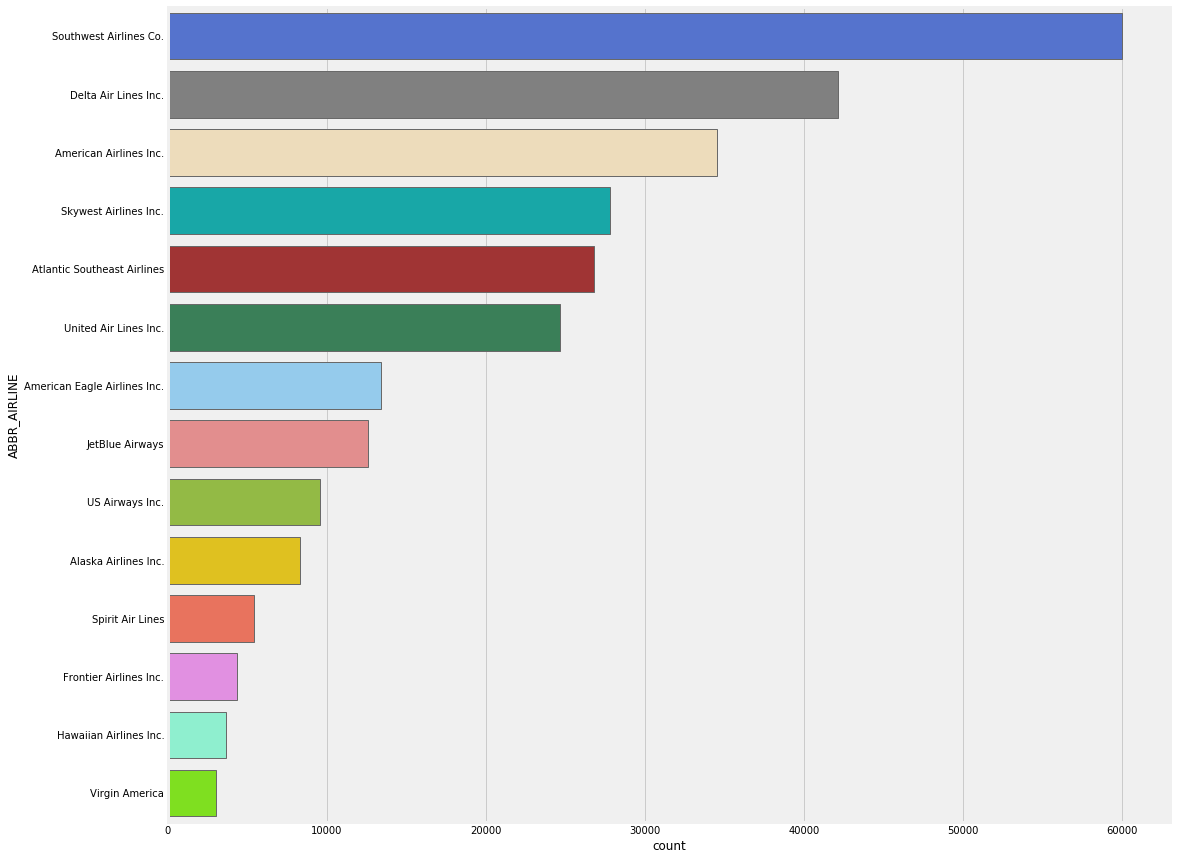

In [58]:
plt.figure(figsize=(16,15))
ax3 = sns.countplot(y='ABBR_AIRLINE', palette = colors,
                    data=df,order = df['ABBR_AIRLINE'].value_counts().index)

In [59]:
df['ABBR_AIRLINE'].value_counts()

Southwest Airlines Co.          60026
Delta Air Lines Inc.            42151
American Airlines Inc.          34536
Skywest Airlines Inc.           27790
Atlantic Southeast Airlines     26785
United Air Lines Inc.           24645
American Eagle Airlines Inc.    13406
JetBlue Airways                 12601
US Airways Inc.                  9569
Alaska Airlines Inc.             8325
Spirit Air Lines                 5413
Frontier Airlines Inc.           4380
Hawaiian Airlines Inc.           3635
Virgin America                   3006
Name: ABBR_AIRLINE, dtype: int64

_Airline with most __DELAYED__ flight recorded_


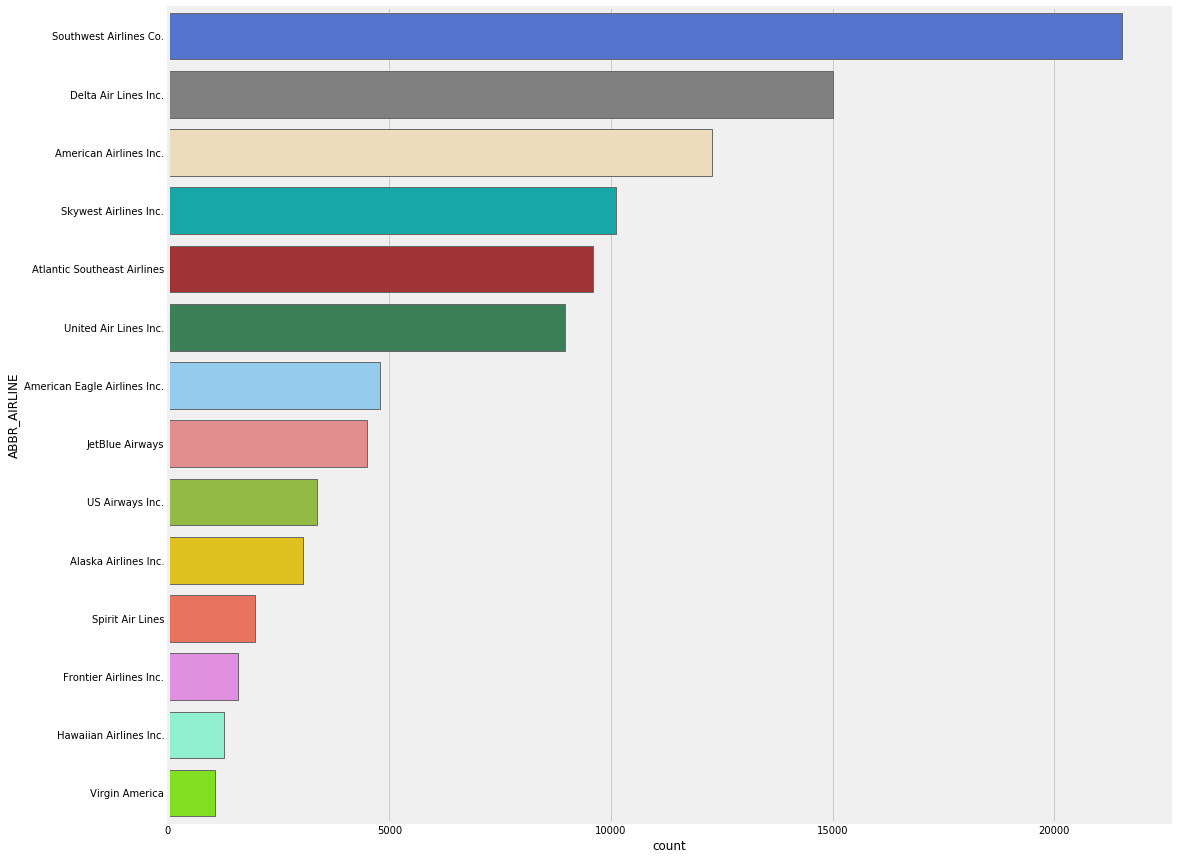

In [60]:
plt.figure(figsize=(16,15))
ax3 = sns.countplot(y='ABBR_AIRLINE', palette = colors,
                    data=df[df['DELAY']==1],
                    order = df[df['DELAY']==1]['ABBR_AIRLINE'].value_counts().index)

In [61]:
df[df['DELAY']==1]['ABBR_AIRLINE'].value_counts()

Southwest Airlines Co.          21540
Delta Air Lines Inc.            15006
American Airlines Inc.          12277
Skywest Airlines Inc.           10125
Atlantic Southeast Airlines      9596
United Air Lines Inc.            8953
American Eagle Airlines Inc.     4778
JetBlue Airways                  4498
US Airways Inc.                  3357
Alaska Airlines Inc.             3058
Spirit Air Lines                 1958
Frontier Airlines Inc.           1576
Hawaiian Airlines Inc.           1270
Virgin America                   1059
Name: ABBR_AIRLINE, dtype: int64

Since the data for each of the Airlines variate, Ratio of delayed and total data is shown below

In [62]:
airlines_count = df['ABBR_AIRLINE'].value_counts().sort_index()
delay_1 = df[df['DELAY']==1]['ABBR_AIRLINE'].value_counts().sort_index()

delay_pct = delay_1/airlines_count
delay_pct = delay_pct.sort_values(ascending=False)
delay_pct

Alaska Airlines Inc.            0.367327
Skywest Airlines Inc.           0.364340
United Air Lines Inc.           0.363279
Spirit Air Lines                0.361722
Frontier Airlines Inc.          0.359817
Southwest Airlines Co.          0.358845
Atlantic Southeast Airlines     0.358260
JetBlue Airways                 0.356956
American Eagle Airlines Inc.    0.356408
Delta Air Lines Inc.            0.356006
American Airlines Inc.          0.355484
Virgin America                  0.352295
US Airways Inc.                 0.350820
Hawaiian Airlines Inc.          0.349381
Name: ABBR_AIRLINE, dtype: float64

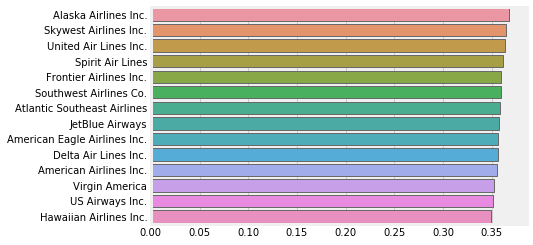

In [63]:
ax = sns.barplot(x=delay_pct.values,y=delay_pct.index)

_From this we can somewhat conclude that all airlines delay possibilty are more or less the same so there is not so much of a significant correlation here._

Although airline company are not that relavant to delayed flight, it turns out that the duration of the delay has some correlation to the airlines companies as shown below

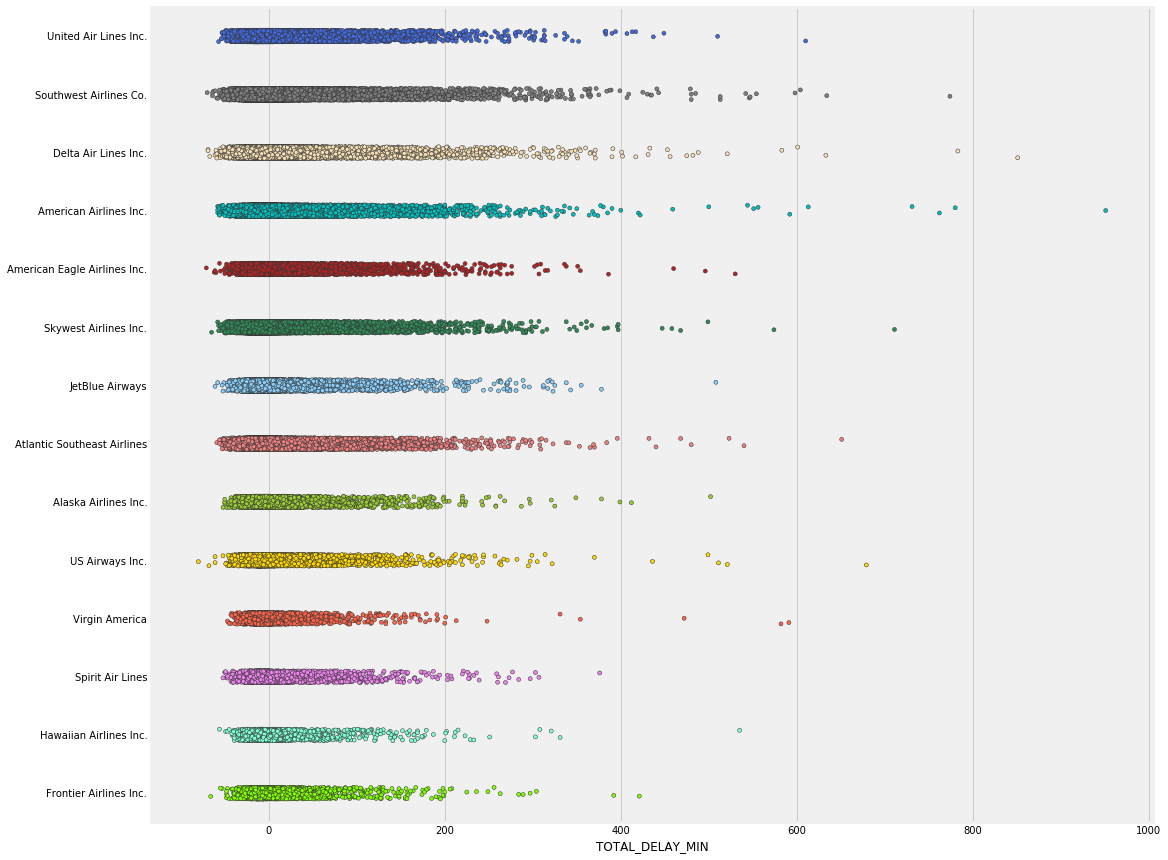

In [64]:
plt.figure(figsize=(16,15))
labels = [s for s in  des_total_delay.index]
ax3 = sns.stripplot(y='ABBR_AIRLINE', x='TOTAL_DELAY_MIN', size = 4, palette = colors,
                    data=df, linewidth = 0.5,  jitter=True)
ax3.yaxis.label.set_visible(False)

_From that graph we can conclude that Virgin America has the least duration of delay(on avg) in this data and Southwest Airlines has longer delays_

__Now comparing the correlation between departure time(SD_MONTH) to the total delay in min (TOTAL_DELAY_MIN)__

In [65]:
df['SD_MONTH']=df['SCHEDULED_DEPARTURE'].dt.month

In [66]:
df = df[['AIRLINE', 'ABBR_AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
         'DISTANCE','SD_MONTH','SCHEDULED_DEPARTURE', 'DEPARTURE_TIME',
         'DEPARTURE_DELAY','SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
         'ARRIVAL_DELAY', 'TAXI_OUT','WHEELS_OFF', 'AIR_TIME', 
         'WHEELS_ON', 'TAXI_IN', 'ELAPSED_TIME','SCHEDULED_TIME', 
         'TOTAL_DELAY', 'TOTAL_DELAY_MIN', 'DELAY']]

In [67]:
df.head()

,AIRLINE,ABBR_AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DISTANCE,SD_MONTH,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,TAXI_OUT,WHEELS_OFF,AIR_TIME,WHEELS_ON,TAXI_IN,ELAPSED_TIME,SCHEDULED_TIME,TOTAL_DELAY,TOTAL_DELAY_MIN,DELAY
0,UA,United Air Lines Inc.,FLL,CLE,1062,4,2015-04-04 11:04:00,2015-04-04 10:59:00,-5.0,2015-04-04 14:00:00,2015-04-04 13:50:00,-10.0,13.0,1112.0,149.0,1341.0,9.0,171.0,176.0,-1 days +23:50:00,-10.0,0
1,WN,Southwest Airlines Co.,PHX,LAX,370,6,2015-06-22 09:00:00,2015-06-22 10:18:00,78.0,2015-06-22 10:30:00,2015-06-22 11:33:00,63.0,14.0,1032.0,53.0,1125.0,8.0,75.0,90.0,01:03:00,63.0,1
2,DL,Delta Air Lines Inc.,SAN,DTW,1956,12,2015-12-27 11:35:00,2015-12-27 11:29:00,-6.0,2015-12-27 18:59:00,2015-12-27 18:53:00,-6.0,29.0,1158.0,229.0,1847.0,6.0,264.0,264.0,-1 days +23:54:00,-6.0,0
3,WN,Southwest Airlines Co.,MKE,RSW,1183,5,2015-05-21 06:05:00,2015-05-21 05:58:00,-7.0,2015-05-21 10:00:00,2015-05-21 09:50:00,-10.0,17.0,615.0,151.0,946.0,4.0,172.0,175.0,-1 days +23:50:00,-10.0,0
4,WN,Southwest Airlines Co.,MDW,CLE,307,7,2015-07-05 22:15:00,2015-07-05 22:13:00,-2.0,2015-07-05 00:20:00,2015-07-05 00:24:00,4.0,14.0,2227.0,50.0,17.0,7.0,71.0,65.0,00:04:00,4.0,1


Text(0,0.5,'Total Delay(min)')

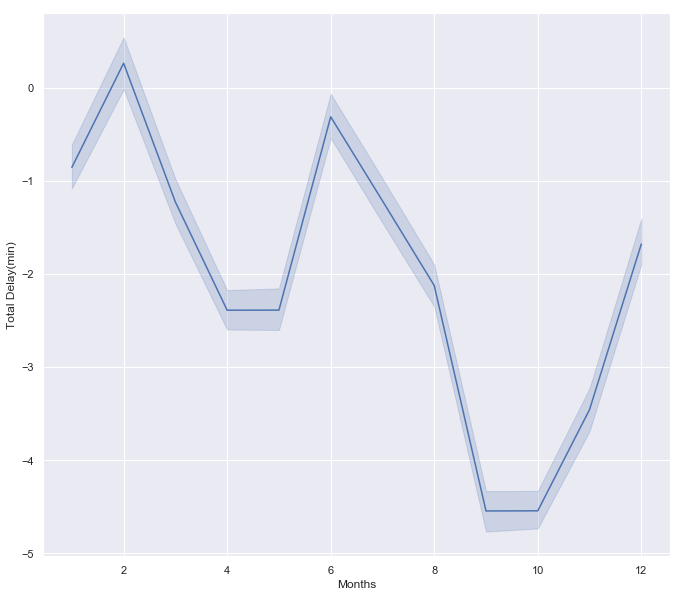

In [80]:
plt.figure(figsize=(10,10))
ax = sns.lineplot(x='SD_MONTH', y="TOTAL_DELAY_MIN",
                  data=df)
ax.set_xlabel('Months')
ax.set_ylabel('Total Delay(min)')

__DELAY VS MONTHS__

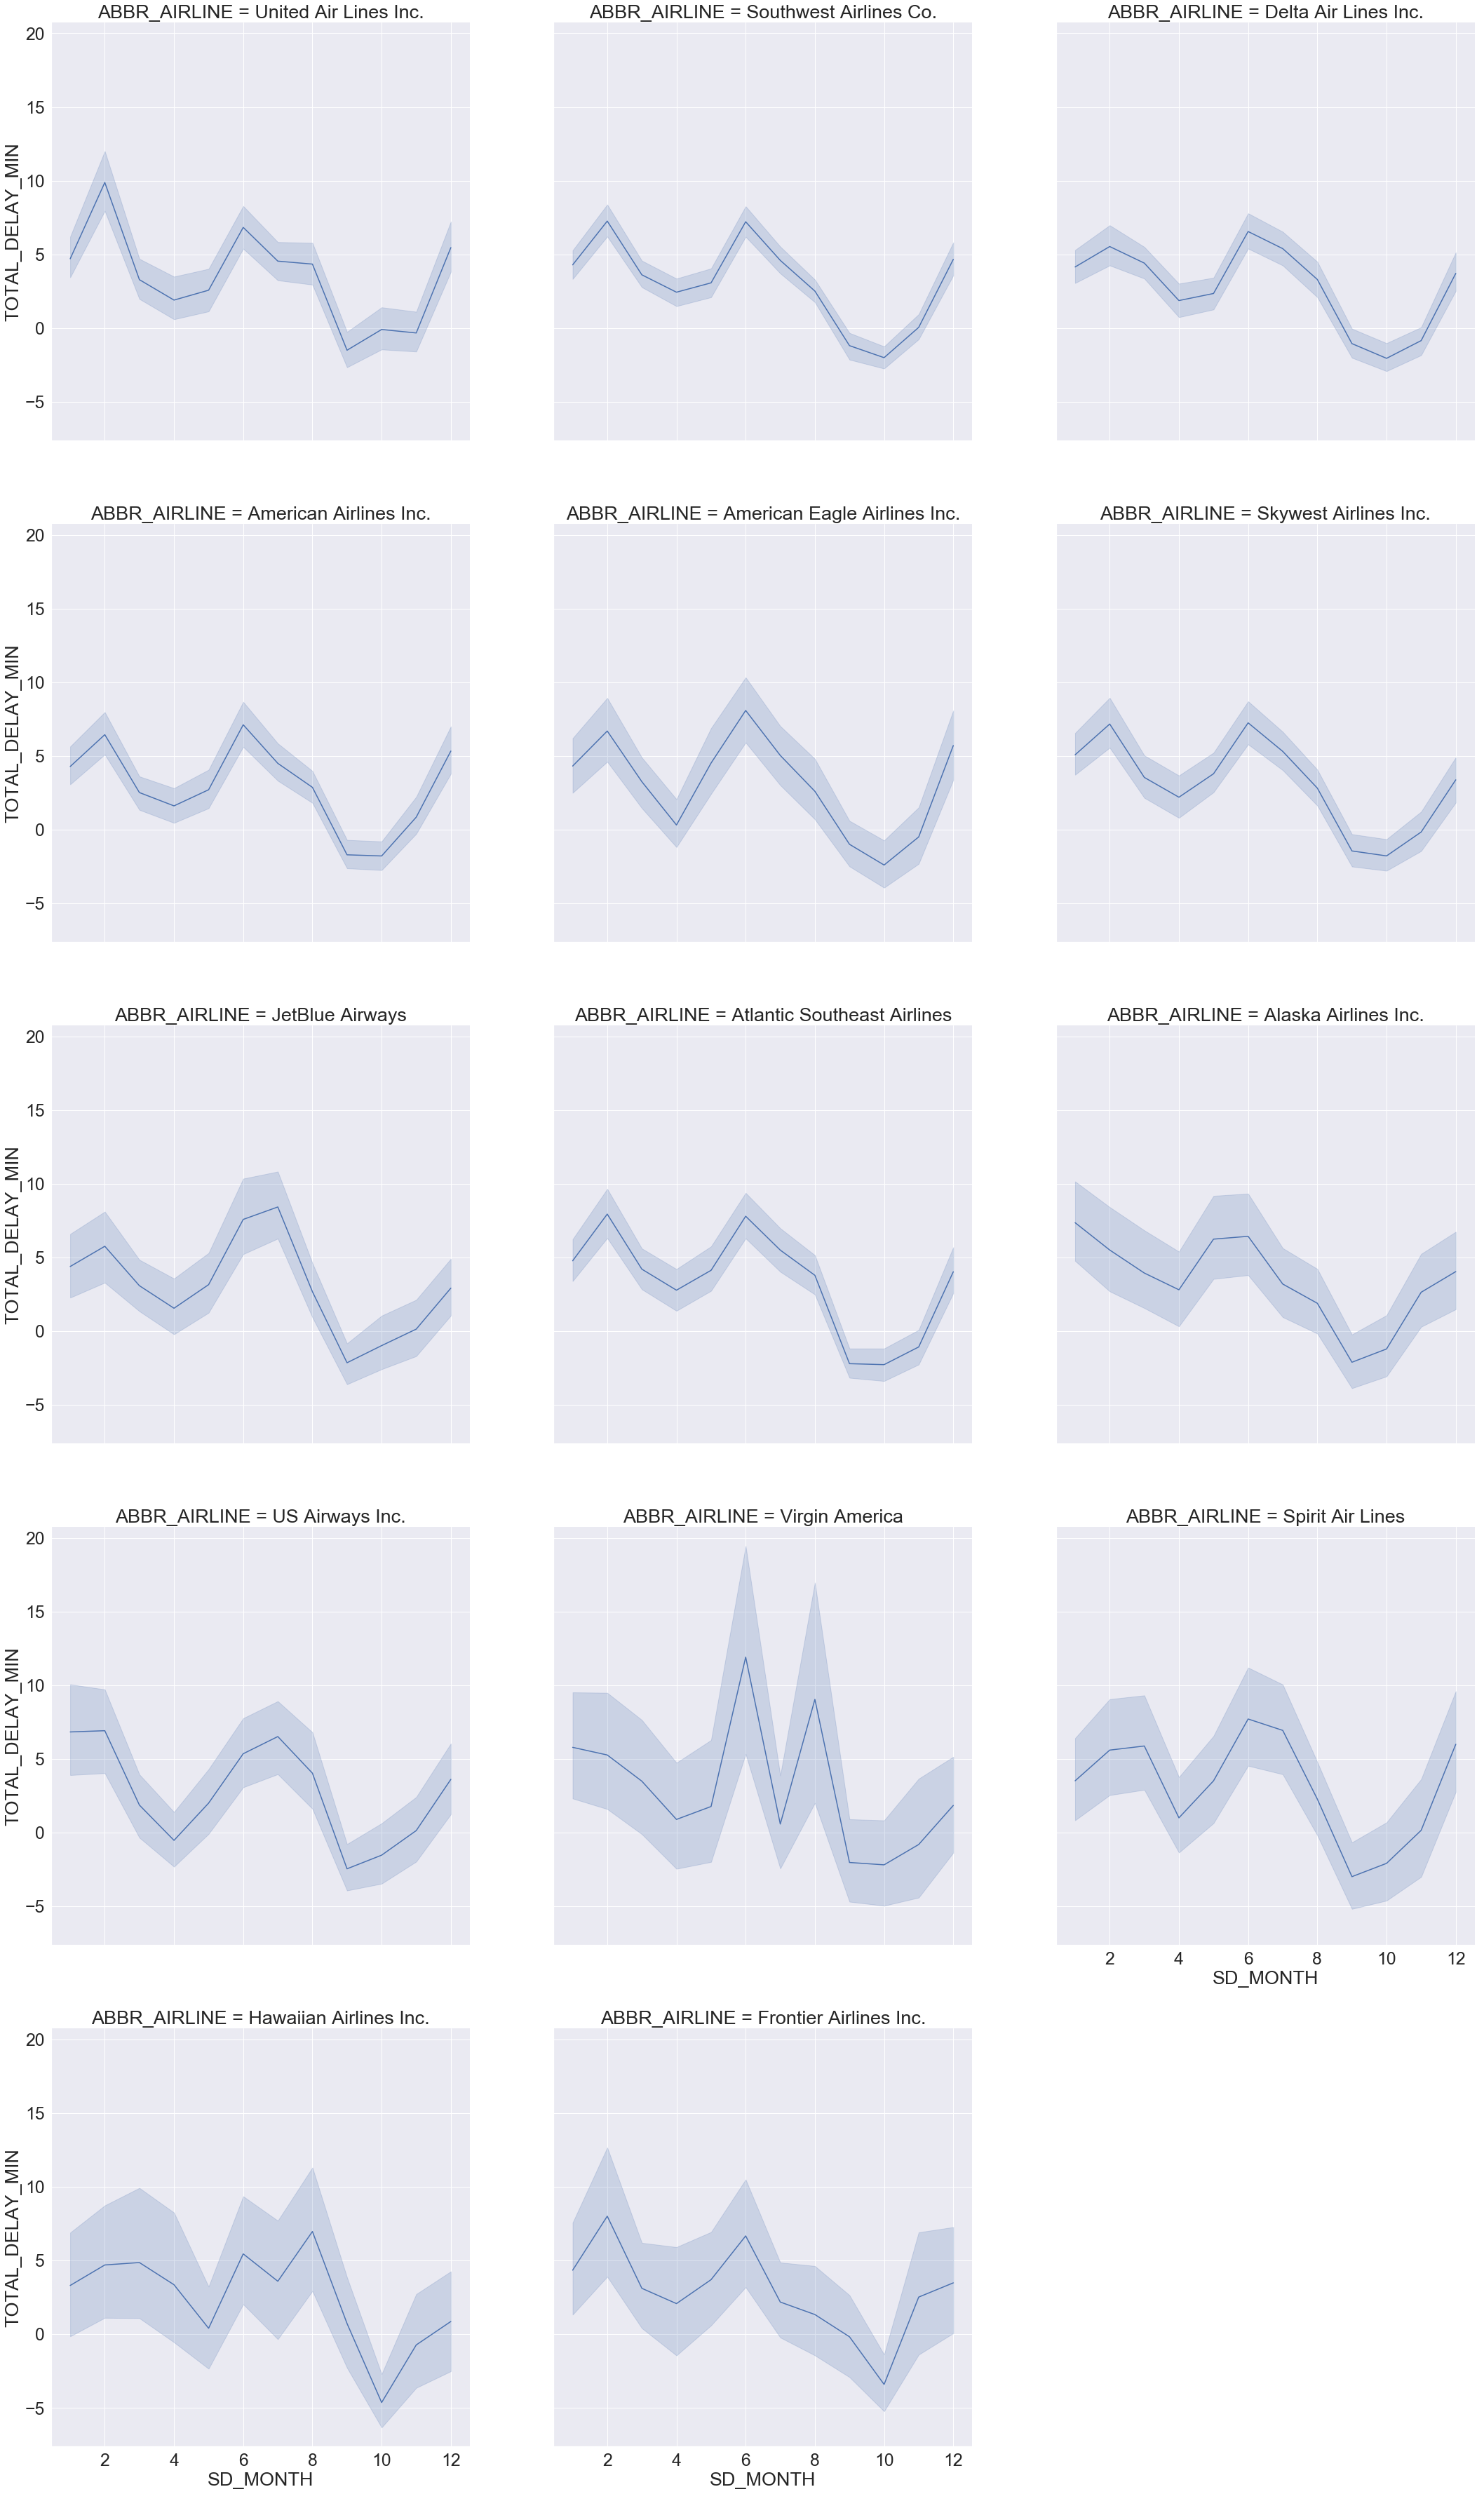

In [69]:
sns.set(font_scale=2.25)
g = sns.FacetGrid(df, col='ABBR_AIRLINE',col_wrap=3,height=10)
g = g.map(sns.lineplot,'SD_MONTH',"TOTAL_DELAY_MIN")
g.fig.subplots_adjust(wspace=0.2, hspace=0.2)


From the graph above we can say that delay time is peaking on February, June, and December. Those months are the common vacation time which means more people are traveling so that the airports are very busy. Furthermore, all of the airlines shows similar pattern.

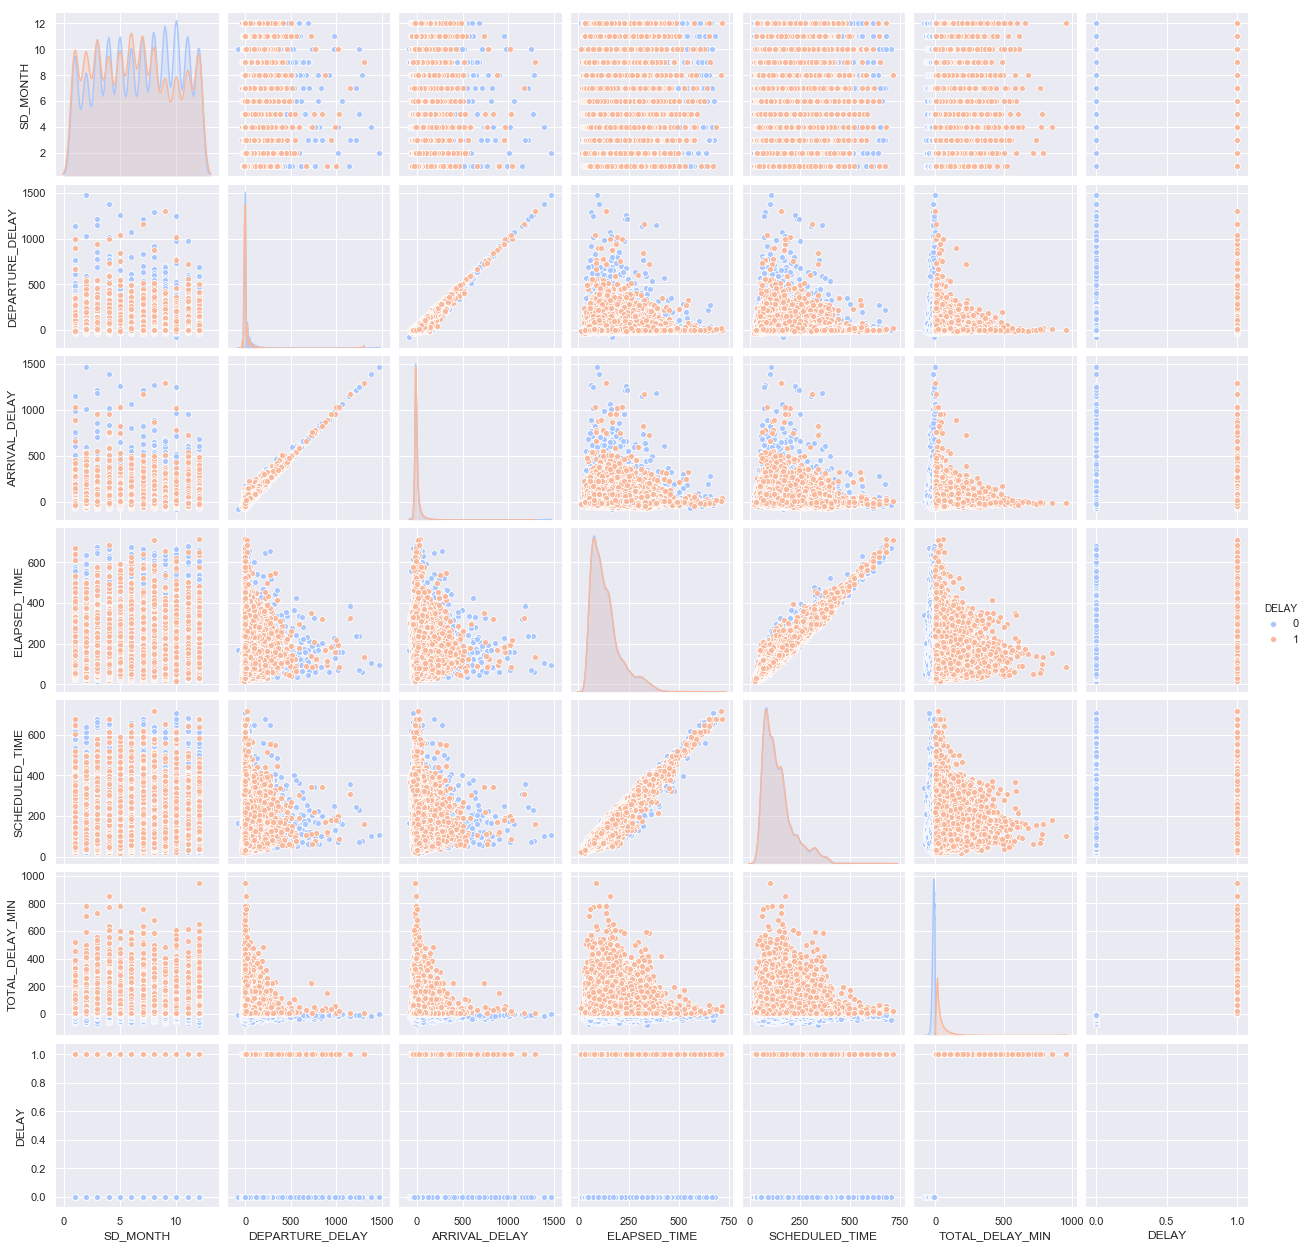

In [70]:
sns.set()
g = sns.pairplot(df[['SD_MONTH','DEPARTURE_DELAY','ARRIVAL_DELAY','ELAPSED_TIME',
         'SCHEDULED_TIME','TOTAL_DELAY_MIN','DELAY']],hue='DELAY',palette = 'coolwarm')
g.fig.subplots_adjust(wspace=0.05, hspace=0.05)

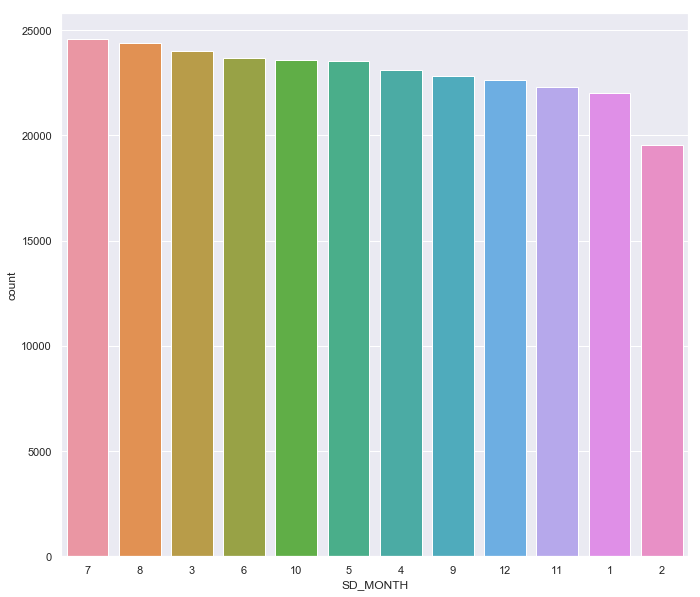

In [71]:
plt.figure(figsize=(10,10))
sns.countplot(x='SD_MONTH',data=df,
              order = df['SD_MONTH'].value_counts().index)

__plotting delayed flight count per month__

Text(0.5,1,'Number of Delay Flights per Month')

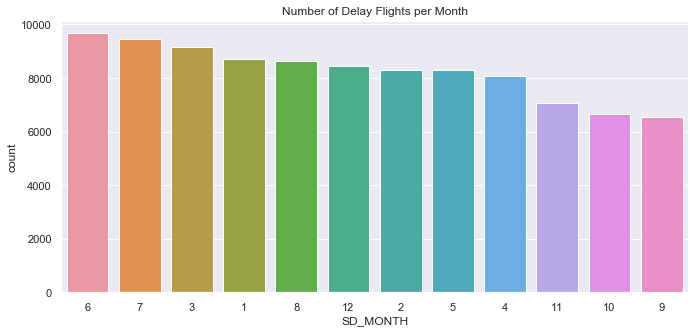

In [72]:
plt.figure(figsize=(10,5))
g = sns.countplot(x='SD_MONTH',data=df[df['DELAY']==1],
              order = df[df['DELAY']==1]['SD_MONTH'].value_counts().index)
g.set_title("Number of Delay Flights per Month")

Turns out June is the month with the most delayed flight, we can say that it is the start of summer holiday and many people travels, thus the busyness of the airports increases which causing more flights to be delayed

__DELAY VS DISTANCE__

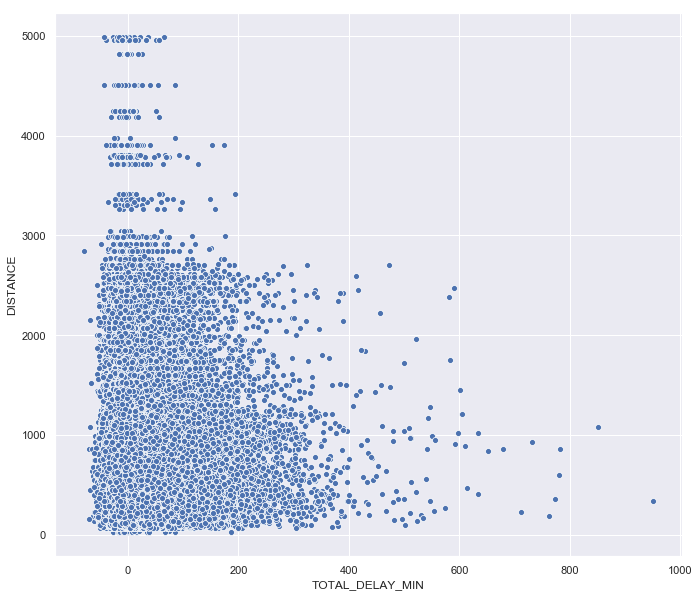

In [73]:
plt.figure(figsize=(10,10))
g = sns.scatterplot(x='TOTAL_DELAY_MIN',y='DISTANCE',data=df)


The graph above shows that there is not much of a correlation within those two features but we can somewhat say that the probability of being delayed is higher when the distance is closer

__Heatmap to see how else the delay is correlated__

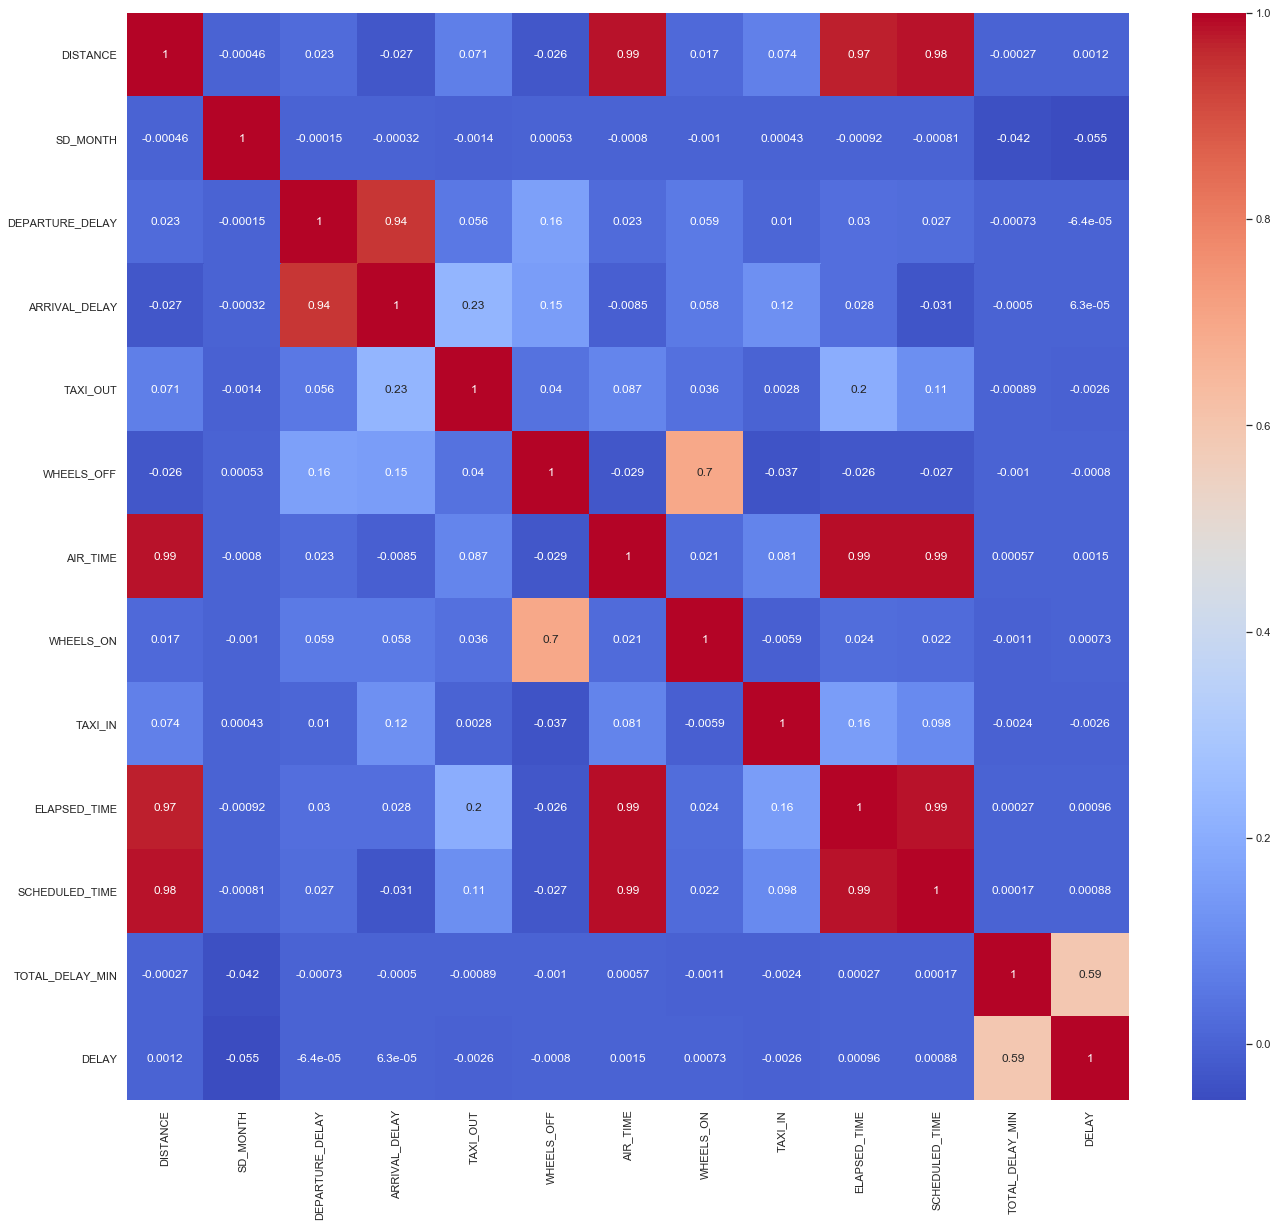

In [74]:
plt.subplots(figsize=(20,20))
sns.heatmap(df.corr(),annot=True,cmap='coolwarm')

From the graph above the strongest correlation with the delay is the month followed by air time and distance.

__Checking the origin airport that has the most delayed flight__

In [75]:
gb_origin = df.groupby('ORIGIN_AIRPORT')
origin_delay = gb_origin.DELAY.sum().sort_values(ascending=False)
origin_delay.head()

ORIGIN_AIRPORT
ATL    5839
ORD    4836
DFW    4000
DEN    3333
LAX    3294
Name: DELAY, dtype: int64

Text(0.5,0,'Number of Delays occur')

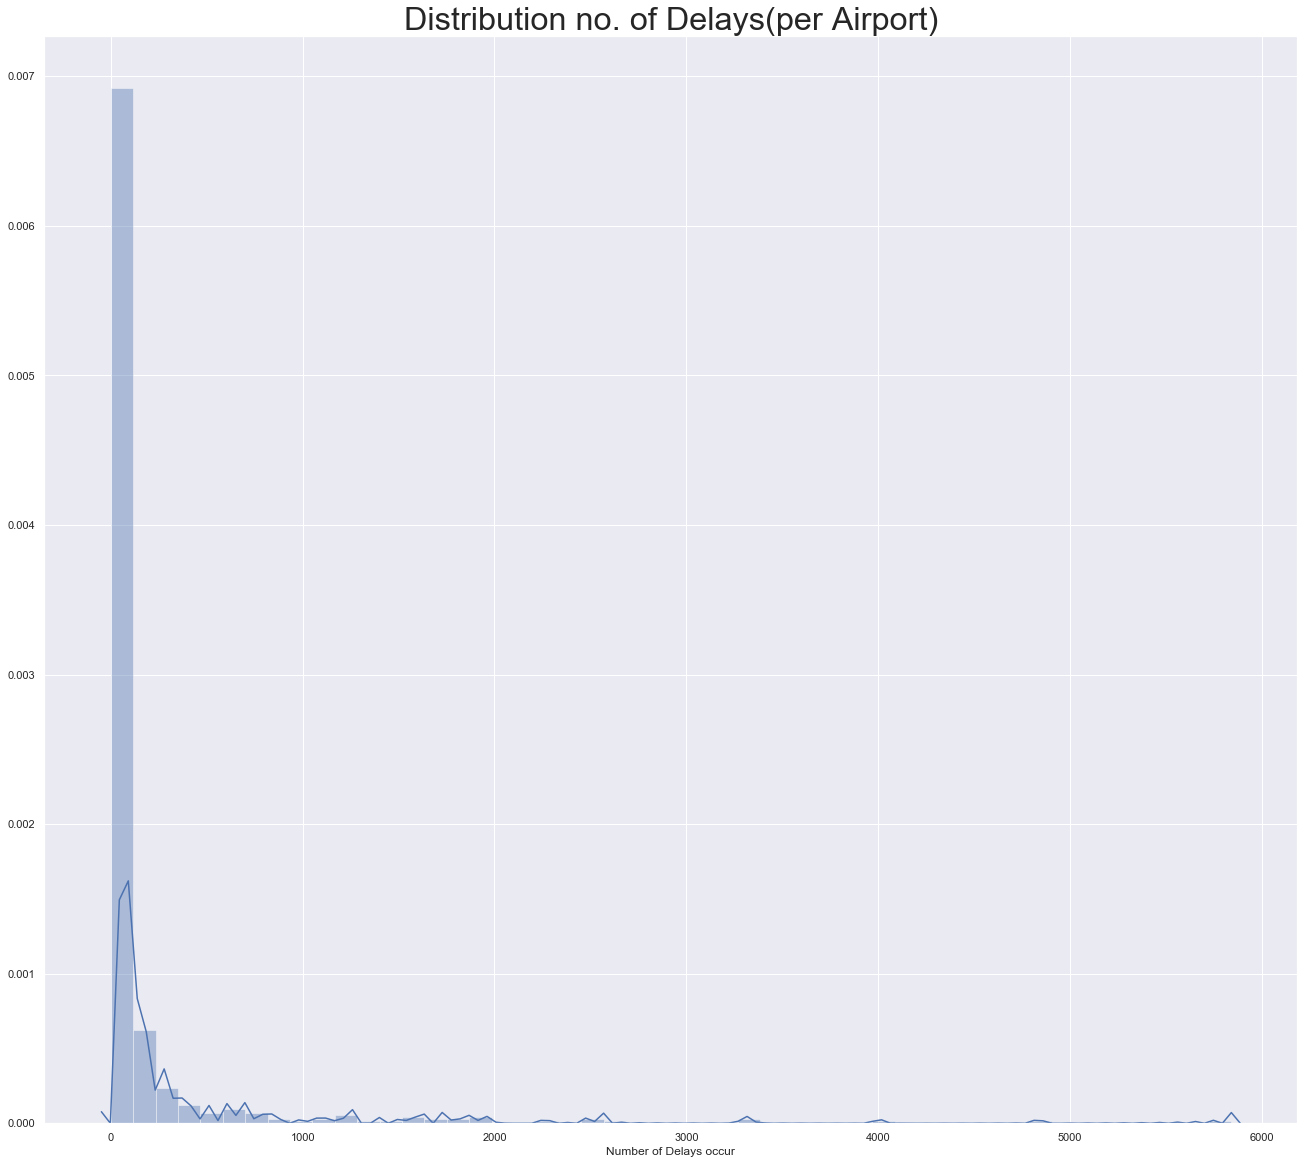

In [76]:
plt.subplots(figsize=(20,20))
sns.set(font_scale=2.7)
g = sns.distplot(origin_delay)
g.set_title("Distribution no. of Delays(per Airport)")
g.set_xlabel('Number of Delays occur')

In [77]:
sns.set()

The distribution trends towards 0-1000 number of delays per aiport but only on a couple of airports that has >3000 flight delays occurance. This means that in a particular airport(>3000) it has higher probabilty to have a delayed flight. As for other airports it cannot be concluded much since most of the 0 delays origin airport is lacking of that from that airport

In [78]:
condition = ((-30<df['TOTAL_DELAY_MIN'])&(df['TOTAL_DELAY_MIN']<=60))&(df['DEPARTURE_DELAY']<=50)&(df['ARRIVAL_DELAY']<=50)
df = df[condition]

In [79]:
df.max()

AIRLINE                                 WN
ABBR_AIRLINE                Virgin America
ORIGIN_AIRPORT                         YUM
DESTINATION_AIRPORT                    YUM
DISTANCE                              4983
SD_MONTH                                12
SCHEDULED_DEPARTURE    2015-12-31 23:59:00
DEPARTURE_TIME         2015-12-31 23:57:00
DEPARTURE_DELAY                         50
SCHEDULED_ARRIVAL      2015-12-31 23:59:00
ARRIVAL_TIME           2015-12-31 23:59:00
ARRIVAL_DELAY                           50
TAXI_OUT                               102
WHEELS_OFF                            2400
AIR_TIME                               661
WHEELS_ON                             2400
TAXI_IN                                 89
ELAPSED_TIME                           715
SCHEDULED_TIME                         718
TOTAL_DELAY                0 days 01:00:00
TOTAL_DELAY_MIN                         60
DELAY                                    1
dtype: object

df.to_csv('flights_sample_cleaned.csv',index=False)